In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 1
SEGMENT = 3

ELECTRON = False
G_COORD = False
L_COORD = False

EPOCH = 100

In [6]:
VIEW_BOUND = (-500, 500)
AIR_BOUND = (-500, -499)
BONE_BOUND = (255, 256)
if ELECTRON:
    VIEW_BOUND = (0.5, 1.5)
    AIR_BOUND = (0.5, 0.5009)
    BONE_BOUND = (1.2, 1.2009)    

### Model Settings

#### encoder

In [7]:
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

In [8]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [9]:
DECODER_ATT = "scse"

#### head

In [10]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [11]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 3e-4
GEN_momentum = 0.9

In [12]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

In [13]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

E_IN_CHANNELS = 1
E_N_CLASSES = 2

# Epochs

In [14]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [15]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [16]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [17]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [18]:
perceptual_ext = PerceptualLoss()

In [19]:
sobel_filter = Sobel().to(device)

In [20]:
def train_d_epoch(epoch, generator_ab, generator_ba,
                  discriminator_a, discriminator_b, d_optim,
                  edge_discriminator_a, edge_discriminator_b, edge_optim,
                    dataloader, device):

    # change mode to train and move to current device
    generator_ab = generator_ab.eval().to(device)
    generator_ba = generator_ba.eval().to(device)
    discriminator_a = discriminator_a.train().to(device)
    discriminator_b = discriminator_b.train().to(device)
    edge_discriminator_a = discriminator_a.train().to(device)
    edge_discriminator_b = discriminator_b.train().to(device)
    
    a_dis_l = 0
    b_dis_l = 0
    edge_a_dis_l = 0
    edge_b_dis_l = 0

    set_requires_grad(discriminator_a, True)
    set_requires_grad(discriminator_b, True)
    set_requires_grad(edge_discriminator_a, True)
    set_requires_grad(edge_discriminator_b, True)
    set_requires_grad(generator_ab, False)
    set_requires_grad(generator_ba, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, *_ = data
 
        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)

        y_pr = generator_ab(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        x_pr = generator_ba(y.float())
        x_pr = Activation(name=GEN_ACT)(x_pr)
        
        d_optim.zero_grad()
       ############################
        # (1) Update D network
        ###########################

        x_cls = discriminator_a(x.float())
        x_pr_cls = discriminator_a(x_pr.detach())

        a_dis = 0
        for _x_cls, _x_pr_cls in \
            zip(x_cls, x_pr_cls):
            _B, _C = _x_cls.size()
            a_dis = nn.CrossEntropyLoss()(_x_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_x_pr_cls.float(), torch.ones(_B, dtype=torch.long, device=device)) + \
                            a_dis
        a_dis = a_dis / (len(x_cls))
        
        y_cls = discriminator_b(y.float())
        y_pr_cls = discriminator_b(y_pr.detach())

        b_dis = 0
        for _y_cls, _y_pr_cls in \
            zip(y_cls, y_pr_cls):
            _B, _C = _y_cls.size()
            b_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_B, dtype=torch.long, device=device)) + \
                            b_dis
        b_dis = b_dis / (len(y_cls))
        
        _loss = a_dis + b_dis
        _loss.backward()
        d_optim.step()

        a_dis_l += a_dis.item()
        b_dis_l += b_dis.item()
        
        edge_optim.zero_grad()
       ############################
        # (1) Update DEnetwork
        ###########################
        edge_y_pr = sobel_filter(y_pr).float()
        edge_x_pr = sobel_filter(x_pr).float()
        edge_y = sobel_filter(y).float()
        edge_x = sobel_filter(x).float()
        
        edge_x_cls = edge_discriminator_a(edge_x)
        edge_x_pr_cls = edge_discriminator_a(edge_x_pr.detach())

        edge_a_dis = 0
        for _edge_x_cls, _edge_x_pr_cls in \
            zip(edge_x_cls, edge_x_pr_cls):
            _B, _C = _edge_x_cls.size()
            edge_a_dis = nn.CrossEntropyLoss()(_edge_x_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_edge_x_pr_cls.float(), torch.ones(_B, dtype=torch.long, device=device)) + \
                            edge_a_dis
        edge_a_dis = edge_a_dis / (len(edge_x_cls))
        
        edge_y_cls = edge_discriminator_b(edge_y.float())
        edge_y_pr_cls = edge_discriminator_b(edge_y_pr.detach())

        edge_b_dis = 0
        for _edge_y_cls, _edge_y_pr_cls in \
            zip(edge_y_cls, edge_y_pr_cls):
            _B, _C = _edge_y_cls.size()
            edge_b_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_edge_y_pr_cls.float(), torch.ones(_B, dtype=torch.long, device=device)) + \
                            edge_b_dis
        edge_b_dis = edge_b_dis / (len(edge_y_cls))
        
        _loss = edge_a_dis + edge_b_dis
        _loss.backward()
        edge_optim.step()

        a_dis_l += a_dis.item()
        b_dis_l += b_dis.item()
        edge_a_dis_l += edge_a_dis.item()
        edge_b_dis_l += edge_b_dis.item()
        
    return  a_dis_l/(index+1), b_dis_l/(index+1), \
                    edge_a_dis_l/(index+1), edge_b_dis_l/(index+1)

In [21]:
def train_g_epoch(epoch, 
                  generator_ab, generator_ba, gen_optim, 
                    discriminator_a, discriminator_b, 
                  edge_discriminator_a, edge_discriminator_b, 
                    dataloader, device):
    
    # change mode to train and move to current device
    generator_ab = generator_ab.train().to(device)
    generator_ba = generator_ba.train().to(device)
    discriminator_a = discriminator_a.eval().to(device)
    discriminator_b = discriminator_b.eval().to(device)
    edge_discriminator_a = edge_discriminator_a.eval().to(device)
    edge_discriminator_b = edge_discriminator_b.eval().to(device)
    
    gen_edge_a_l = 0
    gen_edge_b_l = 0
    gen_a_l = 0
    gen_b_l = 0
    idt_a_l = 0
    idt_b_l = 0
    air_x_l = 0
    air_y_l = 0
    bone_x_l = 0
    bone_y_l = 0
    
    set_requires_grad(discriminator_a, False)
    set_requires_grad(discriminator_b, False)
    set_requires_grad(generator_ab, True)
    set_requires_grad(generator_ba, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, air_y, bone_y = data

        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        air_y = air_y.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)
        bone_y = bone_y.to(device).view(-1, 1, H, W)
        
        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        
        y_pr = generator_ab(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        x_pr = generator_ba(y.float())
        x_pr = Activation(name=GEN_ACT)(x_pr)
        
        gen_optim.zero_grad()

        # adversarial loss
        y_pr_cls = discriminator_b(y_pr)
        x_pr_cls = discriminator_a(x_pr)
        
        gen_b = 0
        for _y_pr_cls in y_pr_cls:
            _B, _C = _y_pr_cls.size()
            gen_b = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            gen_b
        gen_b = gen_b / (len(y_pr_cls))
        
        gen_a = 0
        for _x_pr_cls in x_pr_cls:
            _B, _C = _x_pr_cls.size()
            gen_a = nn.CrossEntropyLoss()(_x_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            gen_a
        gen_a = gen_a / (len(x_pr_cls))

        # edge adversarial network
        
        edge_y_pr = sobel_filter(y_pr).float()
        edge_x_pr = sobel_filter(x_pr).float()   
        edge_x_pr_cls = edge_discriminator_a(edge_x_pr)
        edge_y_pr_cls = edge_discriminator_a(edge_y_pr)
        
        gen_edge_b = 0
        for _edge_y_pr_cls in edge_y_pr_cls:
            _B, _C = _edge_y_pr_cls.size()
            gen_edge_b = nn.CrossEntropyLoss()(_edge_y_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            gen_edge_b
        gen_edge_b = gen_edge_b / (len(edge_y_pr_cls))
        
        gen_edge_a = 0
        for _edge_x_pr_cls in edge_x_pr_cls:
            _B, _C = _edge_x_pr_cls.size()
            gen_edge_a = nn.CrossEntropyLoss()(_edge_x_pr_cls.float(), torch.zeros(_B, dtype=torch.long, device=device)) + \
                            gen_edge_a
        gen_edge_a = gen_edge_a / (len(edge_x_pr_cls))
        
        ###
        x_recon = generator_ba(y_pr)
        y_recon = generator_ab(x_pr)
        
        idt_a = nn.L1Loss()(x_recon, x)
        idt_b = nn.L1Loss()(y_recon, y)

        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_x_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_x_loss = nn.BCELoss()(air_x_pr.float(), air_x.float())
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_x_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_x_loss = nn.BCELoss()(bone_x_pr.float(), bone_x.float())
        
 
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_y_pr = hu_clip_tensor(x_pr.double(), (lower, upper), None, True)
        air_y_loss = nn.BCELoss()(air_y_pr.float(), air_y.float())
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_y_pr = hu_clip_tensor(x_pr.double(), (lower, upper), None, True)
        bone_y_loss = nn.BCELoss()(bone_y_pr.float(), bone_y.float())
        

        _loss = gen_a + gen_b + gen_edge_a + gen_edge_b + \
                        idt_a + idt_b + air_x_loss + bone_x_loss + air_y_loss + bone_y_loss
        _loss.backward()    
        gen_optim.step()

        gen_edge_a_l += gen_edge_a.item()
        gen_edge_b_l += gen_edge_b.item()
        gen_a_l += gen_a.item()
        gen_b_l += gen_b.item()
        idt_a_l += idt_a.item()
        idt_b_l += idt_b.item()

        air_x_l += air_x_loss.item()
        air_y_l += air_y_loss.item()
        bone_x_l += bone_x_loss.item()
        bone_y_l += bone_y_loss.item()
        
    return  air_x_l/(index+1), air_y_l/(index+1), bone_x_l/(index+1), bone_y_l/(index+1), \
                    gen_a_l/(index+1), gen_b_l/(index+1), gen_edge_a_l/(index+1), gen_edge_b_l/(index+1),\
                    idt_a_l/(index+1), idt_b_l/(index+1)

In [22]:
@torch.no_grad()
def eval_epoch(generator_ab, discriminator_b, dataloader, device):
    
    # change mode to train and move to current device
    generator_ab = generator_ab.eval().to(device)
    discriminator_b = discriminator_b.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []

    air_ = []
    bone_ = []
    cont_ = []

    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, air_y, bone_y = data

        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        air_y = air_y.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)
        bone_y = bone_y.to(device).view(-1, 1, H, W)

        y_pr = generator_ab(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = discriminator_b(y.float())
        for _y_cls in y_cls:
            _y_cls = _y_cls.view(B, T, 2)[:, 1, :]
            _B, _C = _y_cls.size()
            total = _B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(_B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = discriminator_b(y_pr.float())
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = _y_pr_cls.view(B, T, 2)[:, 1, :]
            _B, _C = _y_pr_cls.size()
            total = _B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(_B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]   
            
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################

        x = x.view(B, T, C, H, W)[:, 1, :]
        y = y.view(B, T, 1, H, W)[:, 1, :]
        y_pr = y_pr.view(B, T, 1, H, W)[:, 1, :]
        air_x = air_x.view(B, T, 1, H, W)[:, 1, :]
        bone_x = bone_x.view(B, T, 1, H, W)[:, 1, :]
        
        # main
        _ssim = ssim(y.float(), y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y.float(), 1.0)
        _snr = SNR()(y_pr, y.float())
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]

        # auxilary
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]

        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), \
                    sum(tf_acc)/len(tf_acc)

In [23]:
@torch.no_grad()
def test_epoch(iid, model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = iid
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data
        
        B, T, C, H, W = x.size()
        x = x.to(device).view(-1, C, H, W)
        y = y.to(device).view(-1, 1, H, W)
        air_x = air_x.to(device).view(-1, 1, H, W)
        bone_x = bone_x.to(device).view(-1, 1, H, W)

        y_pr = model(x.float())
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        x = x.view(B, T, C, H, W)[:, 1, :]
        y = y.view(B, T, 1, H, W)[:, 1, :]
        air_x = air_x.view(B, T, 1, H, W)[:, 1, :]
        bone_x = bone_x.view(B, T, 1, H, W)[:, 1, :]
        y_pr = y_pr.view(B, T, 1, H, W)[:, 1, :]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0).float()
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [24]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [25]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Read Data

In [26]:
from codes.dataset import DicomsSegmentDataset, DicomsDataset
import codes.augmentation as aug

In [27]:
pelvic_train_case_path = 'raw/train/*_*'
pelvic_train_id_case_path = 'raw/train_id/*_*'
pelvic_test_case_path = 'raw/test/*_*'

In [28]:
trainset_pelvic = DicomsSegmentDataset(pelvic_train_case_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)
trainset_id_pelvic = DicomsSegmentDataset(pelvic_train_id_case_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)

In [29]:
trainset_pelvic = ConcatDataset([trainset_pelvic, trainset_id_pelvic])

In [30]:
testset = DicomsSegmentDataset(pelvic_test_case_path, geometry_aug=aug.get_validation_augmentation(), 
                 identity=False, electron=ELECTRON, position="pelvic", segment=SEGMENT, g_coord=G_COORD, l_coord=L_COORD)

In [31]:
len(trainset_pelvic), len(testset)

(1344, 191)

In [32]:
x, y, *_ = trainset_pelvic[20]

In [33]:
x.shape, y.shape

((3, 1, 384, 384), (3, 1, 384, 384))

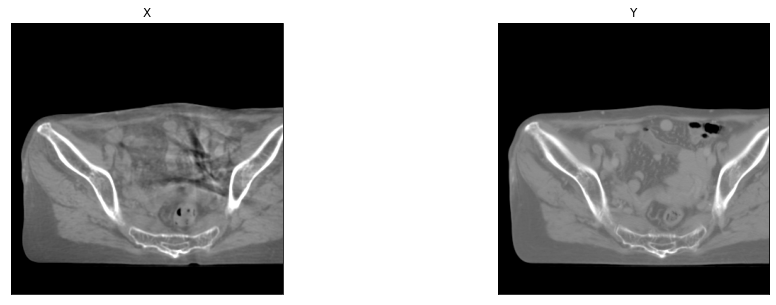

In [34]:
visualize(
    x = x[0][0].squeeze(),
    y = y[0][0].squeeze())

# training

In [35]:
trainloader = torch.utils.data.DataLoader(trainset_pelvic, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

In [36]:
import segmentation_models_pytorch as smp
import torchvision.models as models

generator_a2b = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(generator_a2b)
replace_bn_to_instanceNorm(generator_a2b)


generator_b2a = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(generator_b2a)
replace_bn_to_instanceNorm(generator_b2a)

In [37]:
discriminator_a = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator_a)
replace_bn_to_instanceNorm(discriminator_a)

discriminator_b = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator_b)
replace_bn_to_instanceNorm(discriminator_b)

In [38]:
edge_discriminator_a = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(edge_discriminator_a)
replace_bn_to_instanceNorm(edge_discriminator_a)

edge_discriminator_b = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(edge_discriminator_b)
replace_bn_to_instanceNorm(edge_discriminator_b)

In [39]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(list(generator_a2b.parameters())+list(generator_b2a.parameters()), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
dis_optimizer = Optimizer(list(discriminator_a.parameters())+list(discriminator_b.parameters()), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_optimizer = Optimizer(list(edge_discriminator_a.parameters())+list(edge_discriminator_b.parameters()), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [40]:
from codes.temporal_shift import make_temporal_shift

make_temporal_shift(generator_a2b, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(generator_b2a, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(discriminator_a, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(discriminator_b, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(edge_discriminator_a, SEGMENT, n_div=4, place="blockres")
make_temporal_shift(edge_discriminator_b, SEGMENT, n_div=4, place="blockres")

=> n_segment per stage: [3, 3, 3, 3]
=> Using n_round 2 to insert temporal shift
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 8 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 36 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> n_segment per stage: [3, 3, 3, 3]
=> Using n_round 2 to insert temporal shift
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 8 blocks 

In [41]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
        "electron": ELECTRON,
        "g_coord": G_COORD,
        "l_coord": L_COORD,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [42]:
wandb.watch(generator_a2b)
wandb.watch(discriminator_b)
wandb.watch(generator_b2a)
wandb.watch(discriminator_a)

max_score = 0

for epoch in range(EPOCH):
        
        loss_a_dis, loss_b_dis, loss_edge_a_dis, loss_edge_b_dis = train_d_epoch(epoch, generator_a2b, generator_b2a,                                                                                             
                                                                                                                                                               discriminator_a, discriminator_b, dis_optimizer,
                                                                                                                                                               edge_discriminator_a, edge_discriminator_b, edge_optimizer, 
                                                                                                                                                                trainloader, device)
        loss_x_air, loss_y_air, loss_x_bone, loss_y_bone, \
            loss_a_gen, loss_b_gen, loss_edge_a_gen, loss_edge_b_gen, \
                        loss_a_idt, loss_b_idt = train_g_epoch(epoch, generator_a2b, generator_b2a, gen_optimizer, 
                                                                                                                                                 discriminator_a, discriminator_b,
                                                                                                                                                edge_discriminator_a, edge_discriminator_b, 
                                                                                                                                                 trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, \
        score_tf_acc_train = eval_epoch(generator_a2b, discriminator_b, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, \
        score_tf_acc_test = eval_epoch(generator_a2b, discriminator_b, testloader, device)

        wandb.log({
            "loss idt a": loss_a_idt,
            "loss idt b": loss_b_idt,
            "loss gen a": loss_a_gen,
            "loss gen b": loss_b_gen,
            "loss edge gen a": loss_edge_a_gen,
            "loss edge gen b": loss_edge_b_gen,
            "loss dis a": loss_a_dis,
            "loss dis b": loss_b_dis,
            "loss edge dis a": loss_edge_a_dis,
            "loss edge dis b": loss_edge_b_dis,
            "loss x air": loss_x_air,
            "loss y air": loss_y_air,
            "loss x bone": loss_x_bone,
            "loss y bone": loss_y_bone,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
        })
        
        
        if score_air_test +  score_bone_test + score_psnr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_psnr_test
            checkpoint = {
                "gen_ab": generator_a2b.state_dict(),
                "gen_ba": generator_b2a.state_dict(),
                "dis_a": discriminator_a.state_dict(),
                "dis_b": discriminator_b.state_dict(),
                "gen_optim": gen_optimizer.state_dict(),
                "dis_optim": dis_optimizer.state_dict(),
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))
            print("Epoch={}".format(epoch))

1344it [05:32,  4.04it/s]
1344it [24:50,  1.11s/it]
1344it [01:33, 14.34it/s]
191it [00:13, 14.16it/s]


Epoch=0


1344it [05:19,  4.20it/s]
1344it [24:53,  1.11s/it]
1344it [01:33, 14.37it/s]
191it [00:13, 14.21it/s]


Epoch=1


1344it [05:24,  4.14it/s]
1344it [30:05,  1.34s/it]
1344it [01:34, 14.16it/s]
191it [00:13, 14.07it/s]


Epoch=2


1344it [05:20,  4.20it/s]
1344it [25:06,  1.12s/it]
1344it [01:33, 14.34it/s]
191it [00:13, 14.24it/s]


Epoch=3


1344it [05:19,  4.21it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.30it/s]
191it [00:13, 14.14it/s]
1344it [05:20,  4.20it/s]
1344it [25:06,  1.12s/it]
1344it [01:34, 14.30it/s]
191it [00:13, 14.17it/s]
1344it [05:19,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.33it/s]
191it [00:13, 14.12it/s]
1344it [05:19,  4.20it/s]
1344it [25:05,  1.12s/it]
1344it [01:34, 14.28it/s]
191it [00:13, 14.14it/s]
1344it [05:20,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.30it/s]
191it [00:13, 14.17it/s]
1344it [05:19,  4.20it/s]
1344it [25:05,  1.12s/it]
1344it [01:34, 14.28it/s]
191it [00:13, 14.10it/s]
1344it [05:20,  4.20it/s]
1344it [25:06,  1.12s/it]
1344it [01:33, 14.31it/s]
191it [00:13, 14.16it/s]
1344it [05:19,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.31it/s]
191it [00:13, 14.14it/s]


Epoch=11


1344it [05:20,  4.20it/s]
1344it [25:09,  1.12s/it]
1344it [01:33, 14.30it/s]
191it [00:13, 14.14it/s]
1344it [05:19,  4.21it/s]
1344it [25:06,  1.12s/it]
1344it [01:33, 14.31it/s]
191it [00:13, 14.18it/s]
1344it [05:20,  4.20it/s]
1344it [25:09,  1.12s/it]
1344it [01:34, 14.29it/s]
191it [00:13, 14.15it/s]
1344it [05:19,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.33it/s]
191it [00:13, 14.18it/s]
1344it [05:19,  4.20it/s]
1344it [25:05,  1.12s/it]
1344it [01:33, 14.32it/s]
191it [00:13, 14.16it/s]
1344it [05:19,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.30it/s]
191it [00:13, 14.16it/s]
1344it [05:19,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:33, 14.34it/s]
191it [00:13, 14.18it/s]
1344it [05:20,  4.19it/s]
1344it [25:09,  1.12s/it]
1344it [01:33, 14.30it/s]
191it [00:13, 14.12it/s]
1344it [05:20,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:34, 14.25it/s]
191it [00:13, 14.10it/s]
1344it [05:19,  4.20it/s]
1344it [25:06,  1.12s/it]
1344it [01:34, 14.28i

Epoch=24


1344it [05:19,  4.20it/s]
1344it [25:07,  1.12s/it]
1344it [01:34, 14.26it/s]
191it [00:13, 14.09it/s]
1344it [05:19,  4.20it/s]
1344it [25:06,  1.12s/it]
1344it [01:34, 14.28it/s]
191it [00:13, 14.08it/s]
1344it [05:19,  4.20it/s]
1344it [25:05,  1.12s/it]
1344it [01:34, 14.27it/s]
191it [00:13, 14.08it/s]


Epoch=27


1344it [05:19,  4.21it/s]
1344it [25:07,  1.12s/it]
1344it [01:34, 14.28it/s]
191it [00:13, 14.03it/s]
1344it [05:19,  4.20it/s]
1344it [25:05,  1.12s/it]
1344it [01:34, 14.29it/s]
191it [00:13, 14.12it/s]


Epoch=29


1344it [05:19,  4.20it/s]
1344it [25:06,  1.12s/it]
1344it [01:34, 14.19it/s]
191it [00:13, 14.08it/s]
1344it [05:31,  4.05it/s]
1344it [25:02,  1.12s/it]
1344it [01:34, 14.21it/s]
191it [00:13, 14.06it/s]
1344it [05:20,  4.20it/s]
1344it [25:04,  1.12s/it]
1344it [01:34, 14.20it/s]
191it [00:13, 14.01it/s]
1344it [05:20,  4.19it/s]
1344it [25:01,  1.12s/it]
1344it [01:34, 14.17it/s]
191it [00:13, 14.02it/s]
1344it [05:20,  4.20it/s]
1344it [25:01,  1.12s/it]
1344it [01:34, 14.16it/s]
191it [00:13, 14.08it/s]
1344it [05:20,  4.19it/s]
1344it [25:02,  1.12s/it]
1344it [01:34, 14.15it/s]
191it [00:13, 14.07it/s]
1344it [05:20,  4.19it/s]
1344it [25:03,  1.12s/it]
1344it [01:34, 14.16it/s]
191it [00:13, 14.09it/s]
1344it [05:20,  4.19it/s]
1344it [25:05,  1.12s/it]
1344it [01:35, 14.14it/s]
191it [00:13, 14.07it/s]
1344it [05:20,  4.19it/s]
1344it [25:04,  1.12s/it]
1344it [01:34, 14.15it/s]
191it [00:13, 14.02it/s]
1344it [05:20,  4.19it/s]
1344it [25:04,  1.12s/it]
1344it [01:34, 14.19i

In [43]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [44]:
generator_a2b = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(generator_a2b)
replace_bn_to_instanceNorm(generator_a2b)
make_temporal_shift(generator_a2b, SEGMENT, n_div=4, place="blockres")

generator_a2b.load_state_dict(checkpoint["gen_ab"])

=> n_segment per stage: [3, 3, 3, 3]
=> Using n_round 2 to insert temporal shift
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 8 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 36 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 3 blocks residual
=> Using fold div: 4
=> Using fold div: 4


<All keys matched successfully>

In [45]:
discriminator_b = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(discriminator_b)
replace_bn_to_instanceNorm(discriminator_b)
make_temporal_shift(discriminator_b, SEGMENT, n_div=4, place="blockres")

discriminator_b.load_state_dict(checkpoint["dis_b"])

=> n_segment per stage: [3, 3, 3, 3]
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4
=> Processing stage with 2 blocks residual
=> Using fold div: 4
=> Using fold div: 4


<All keys matched successfully>

In [46]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(generator_a2b, discriminator_b, trainloader, device)

1344it [01:35, 14.13it/s]


(0.8217493842045466,
 22.40815132927327,
 12.97605400124476,
 0.034222319555868,
 0.994751157285942,
 0.8177108956218998,
 0.37139732934260145,
 0.5)

In [47]:
# import torchvision.models as models
# models.vgg16(pretrained=True)